# PCA & K-Means Cluster Analysis of Personal IMDB Ratings
### Objectives:
MODIFIED TO ONLY USE QUANTITATIVE CONTINUOUS VARIABLES,MORE MEANINGFUL RESULTS.
1. Attempting to Find patterns in <b>My IMDb movie Ratings </b>over a period of 5 Years.<b> Find insights about preferences etc., Important Features </b>Using (I) EDA (II) K-Means Clustering.
2. Find <b>Interesting Clusters of Movies Using K-Means Clustering</b>.
3. Use <b>Principal Component Analysis </b>to improve Clustering output.
4. Gathering Insights on preferences by performing <b>hypothesis testing on these clusters</b> with respect to mean Ratings..
5. Data exported using IMDB account export feature. Additional data added using OMDB API, wrangling steps in accompanying wrangling notebook.

### Insights :
<p> <b>Statisticaly Significant Clusters </b>indicate that the author:<br>
    1. Prefers - Prestige Dramas, Moderately popular/Successful Romantic/Comedic Dramas.<br>
    2. Dislikes - Newer Action-Adventure, Sci-Fi , Superhero movies, Newer Hindi Movies.
It was also found that the IMDb rating, Popularity of movies were important positive features, whereas the year of release of a movie had an inverse relationship on the rating on the movie.<br>
<b>Clusters are also formed of films by directors that the author</b> seems to prefer (high mean difference to the overall mean of ratings), These include films by Directors Satyajit Ray, Brad bird, Andrew Stanton, Dean DeBlois, Edgar Wright, Steven Spielberg, Wes Anderson etc.<br>
<b>Clusters of Directors that make longer than average movies</b> were also formed but were not found to have a relevant effect on the preference of the author. The clusters with the most positive deviation in popularity were of films by David Fincher, Christopher Nolan.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from pathlib import Path
import warnings

pd.set_option('display.max_rows', 1000)
warnings.filterwarnings('ignore')

In [100]:
path = str(Path.cwd()) + '/Data/enriched_film_data_april.csv'

data_film = pd.read_csv(path, engine='python', index_col=0)

# Keeping Backup Dataframe
data_film_orig = data_film

## 1. Exploratory Analysis & Visualizations

### Univariate 

#### BoxPlots for Quantitative Vars.
Insights:
1. Most of the Ratings lie between the rating 7 and 8, this is slightly lower compared to the IMDb users, But this could be misleading as Discrete vs Continuous Comaprison.
2. The author generally likes watching Longer Movies.
3. Although most movies watched are newer, their is a long tail towards older movies, author doesn't mind the occassional older movies.
4. Majority of the movies watched are on the lower end of Popularity. 
5. Please ignore Major_awards since it is a binary categorical column. Interesting to note is that the number of films with some form of major awards recognition is higher than those without it.

In [103]:
def plot_box_num_uni(df):
    """ Plots Boxplots for all Numerical Columns in Dataframe.
    """
    fig = plt.figure()
    fig.set_figheight(30)
    fig.set_figwidth(20)
    for i, item in enumerate(df.select_dtypes([np.number]).columns.to_list()):
        ax = fig.add_subplot(len(df.select_dtypes([np.number]).columns.to_list()), 3, i+1)
        sns.boxplot(x = str(item), data = df)
        ax.set_title(item)

    fig.show()

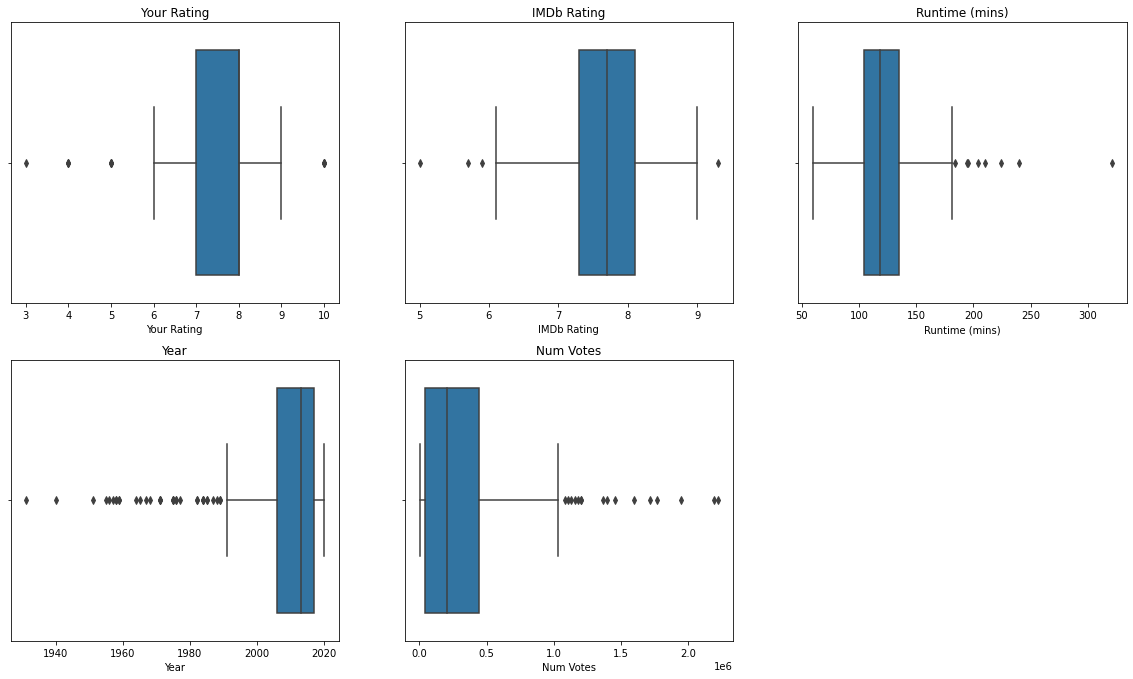

In [106]:
# only using numerical columns and removing binary column
num_columns = data_film.select_dtypes([np.number]).columns.to_list()
num_columns.remove('Major_Awards')
plot_box_num_uni(data_film[num_columns])

#### Division of Ratings accross Genres
Splitting compound Director/Genre and only keeping primary Genre/Director.<br>
Again most common rating appears to be an 8 with only Action movies/Documentaries having a different mode.

In [107]:
data_film[['Genre1','Genre2','Genre3','Genre4','Genre5','Genre6','Genre7']] = data_film.Genres.str.split(',', expand=True)
data_film.drop(['Genre2','Genre3', 'Genre4','Genre5','Genre6','Genre7'], axis= 1, inplace = True)
# Loss of info by dropping secondary, tertiary genres but will result in duplication, is complex.

In [108]:
# Loss of info, Lee ukreich, ethan and joel coen etc are big loosers. Complex fix later.
data_film[['Director1','Director2','Director3', 'Director4']] = data_film.Directors.str.split(',', expand=True)
data_film.drop(['Director2','Director3', 'Director4'], axis = 1, inplace = True)

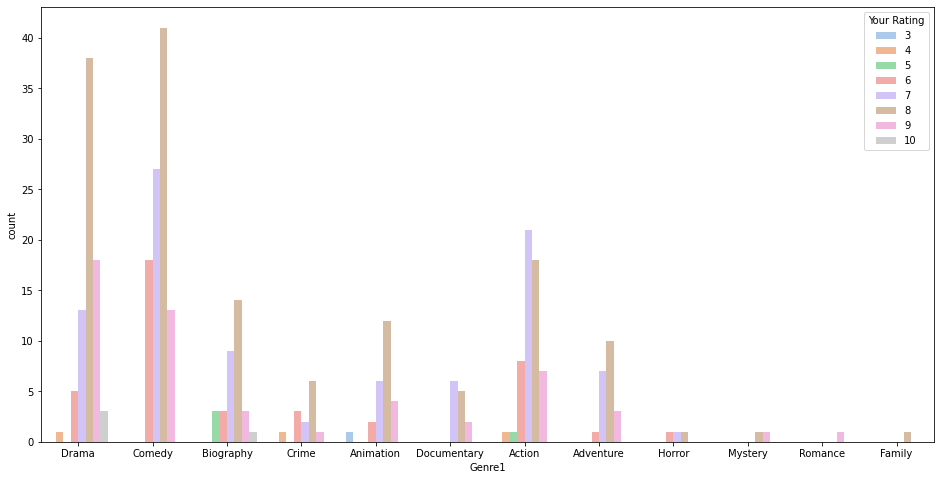

In [109]:
plt.figure(figsize=(16,8))
ax = sns.countplot(x = 'Genre1', data = data_film, hue="Your Rating", palette="pastel")
ax.legend(loc='upper right', title = 'Your Rating')
plt.show()

#### Most Watched Directors

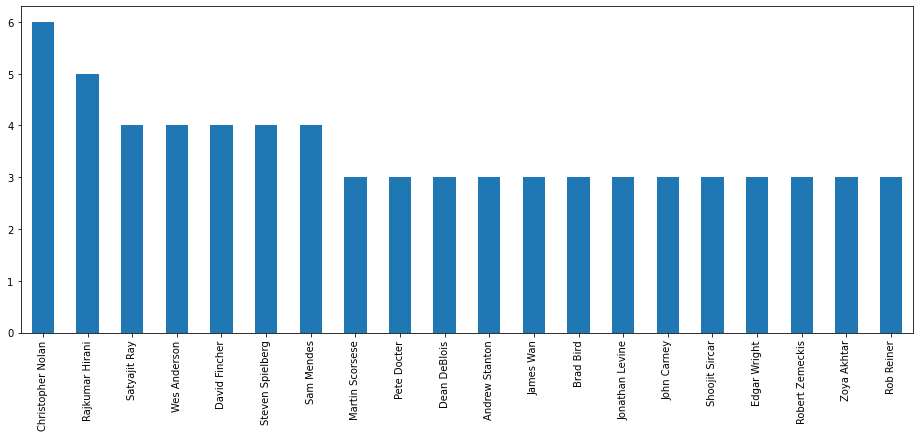

In [110]:
plt.figure(figsize = (16,6))
data_film.Director1.value_counts()[:20].plot(kind = 'bar')
plt.show()

## Bivariate Analysis With Respect to 'Your Rating'
1. I generally follow the same trends as the IMDb ratings. The movies I've rated the highest tend to be highly rated movies in general. There is a large percentage of movies I've rated lower that the IMDb public likes.
2. The lowest rated movies tend to have longer run times compared to the average movies. The highest rated movies tend to be longer too.
3. Most higher rated movies are more spread out when it comes to year of release. The violin plot shows this better.
4. There is high spread in the popularity of the movies rated higher. Will check relationship using Linear Regression later.

In [111]:
def plot_box_num_biv(df, categ):
    """ Plots Boxplots for all Numerical Columns in Dataframe with respect to a target column.
    """
    fig = plt.figure()
    fig.set_figheight(30)
    fig.set_figwidth(20)
    for i, item in enumerate(df.select_dtypes([np.number]).columns.to_list()):
        if categ != item:
            ax = fig.add_subplot(len(df.select_dtypes([np.number]).columns.to_list()), 2, i)
            sns.boxplot(x = categ, y = str(item), data = df)
            ax.set_title(item)

    fig.show()

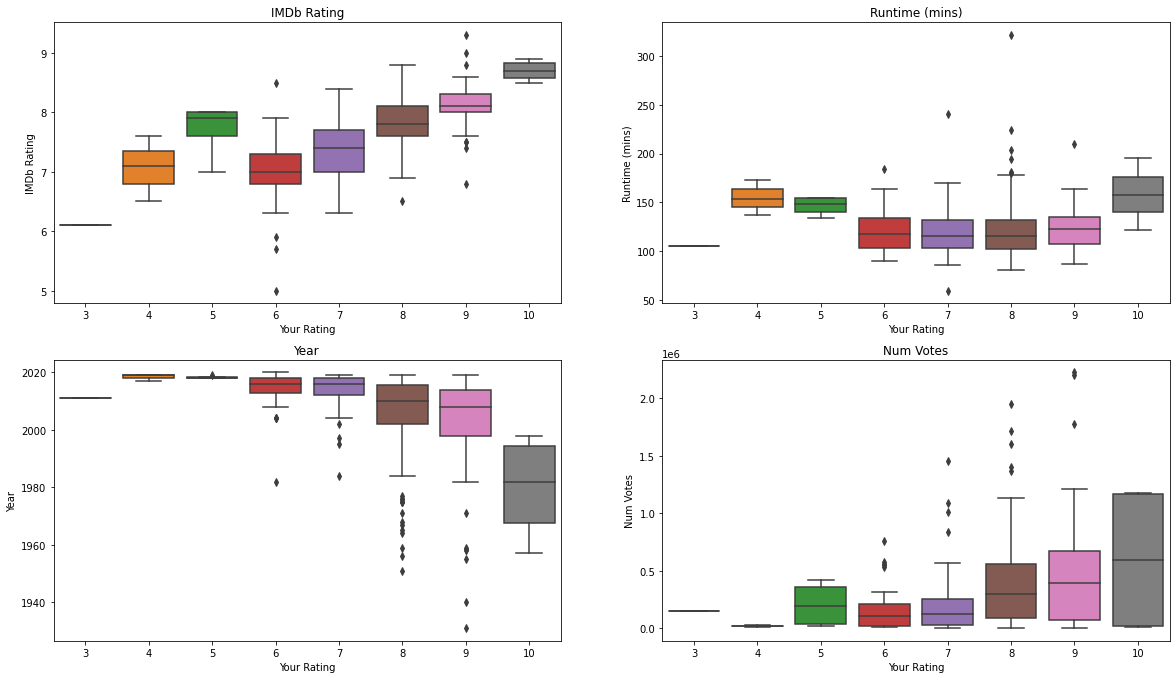

In [112]:
plot_box_num_biv(data_film[num_columns], 'Your Rating')

## Checking Relationships Between Data

### Checking Pearsons Correlation 
The ratings are highly correlated with IMDB User ratings. Their is a Decent positive linear relationship between ratings and Num of votes and negative relationship between rating and year of release. No relationship between runtime and rating.<br>
Since Major awards is a binary column, pearsons r is not particularly mainingful here. 

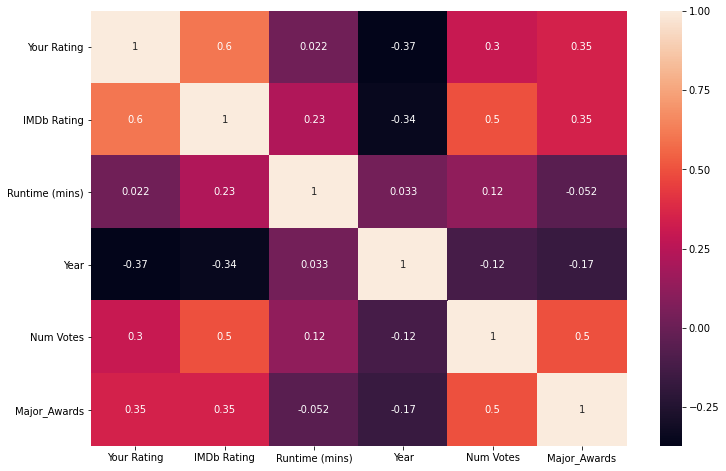

In [113]:
plt.figure(figsize=(12,8))
sns.heatmap(data = data_film.corr(), annot=True)
plt.show()

## Linear Regression Plots to check If there is a Linear Relationships between Your Rating and Other Quantitaive Vars., Comparison with IMDb Users.
0. A strong relationship is not expected between Your Ratings (sample) and IMDb Ratings (population), this is backed up by the first plot. But this is not of interest as we want to know which features contribute most to the Ratings and whether there is significant difference between the author and the IMDB Population.
1. There is a Strong Positive Linear Relationship between IMDb user Ratings and My Ratings, not significantly different ratings, makes sense as movies rated higher by the population would be good movies in geneal. There are quite a few outliers visible. More interested in these values as they could show possible pecularities in taste and important features.
2. No Significant Relationship linear relationship between runtime and Your rating. There are high leverage points. Weaker relationship compared to Imdb Users.
3. Appears to be weak negative relationship between Year of release and Your Rating, stronger than other IMDb users , author favors older movies.
4. Appears to be a weak positive relationship between popularity (Num of votes) and Your rating. Some high leverage points. Comparing with Rating by IMDb users, this relationship appears to be extremely similar but larger confidence interval. So yeah, popular movies tend to be rated higher or vice-versa, again could just be a correlation.

In [115]:
def plot_lin_num_biv(df):
    """ Plots Linear Regression best fit lines for all Numerical Columns in Dataframe with respect your rating column.
    """
    fig = plt.figure()
    fig.set_figheight(30)
    fig.set_figwidth(20)
    for i, item in enumerate(df.select_dtypes([np.number]).columns.to_list()):
        ax = fig.add_subplot((len(df.select_dtypes([np.number]).columns.to_list())), 2, i+1)
        sns.regplot(y = 'Your Rating', x = str(item), data = data_film, label = 'Your Ratings')
        sns.regplot(y = 'IMDb Rating', x = str(item), data = data_film, label = 'IMDb Ratings')
        ax.legend()
        ax.set_ylabel('Rating')
        ax.set_title('IMDb Rating, Your Rating - ' + item)
    fig.savefig('Graphs/Linear_rel.jpg')
    fig.show()

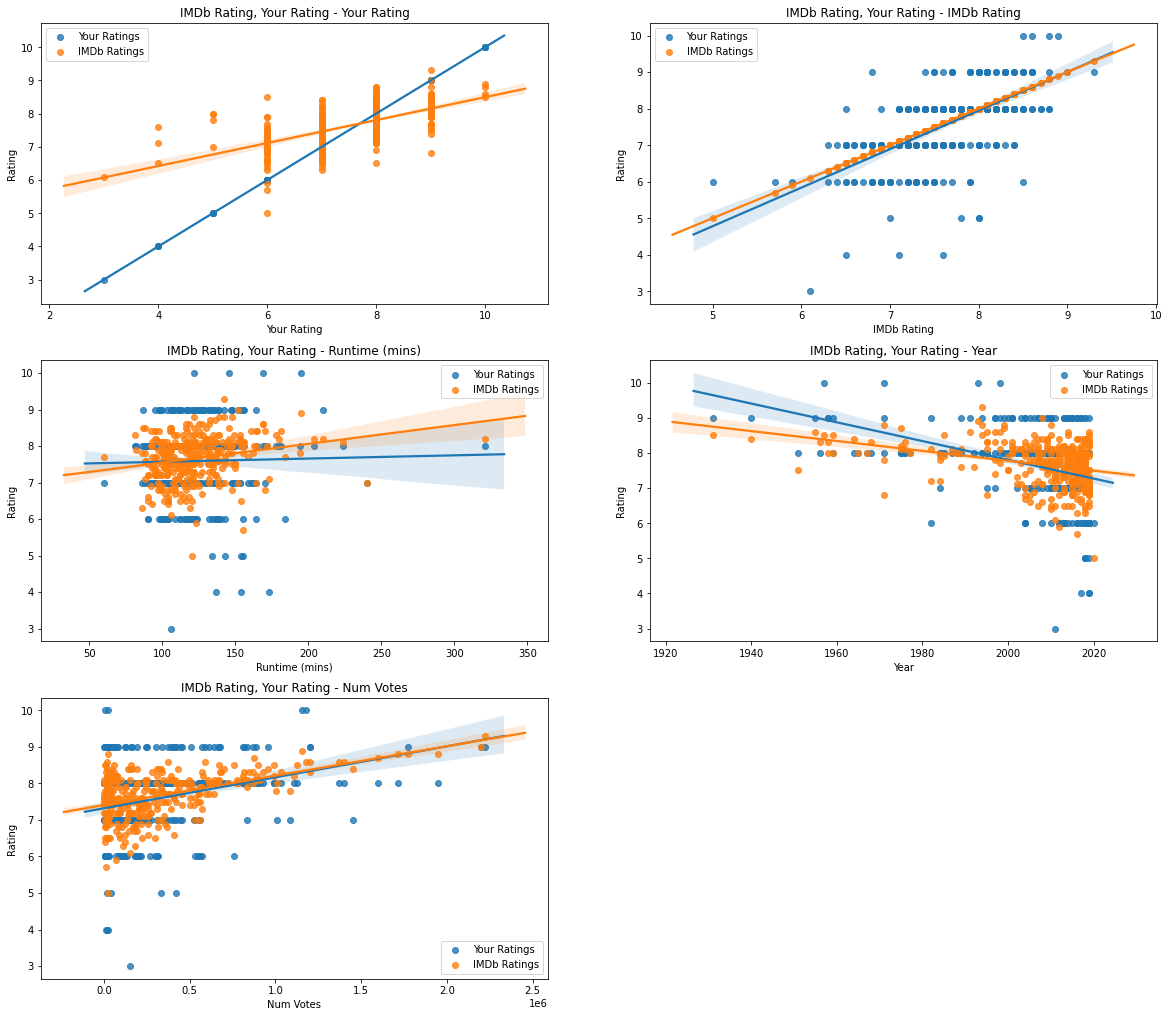

In [116]:
plot_lin_num_biv(data_film[num_columns])

# 2.A. K-Means Clustering (Using Only Continuous Numerical Data)
1. K-Means is a centroid based clustering algorithm that finds distinct clusters on the basis of the Euclidean distance. Used elbow method with within-cluster sum-of-squares and silhoutte score to assess quality of clusters. Finally clusters visualised using T-SNE. 

#### Standardize Data
Clustering requires data to be standardised/scaled since the Euclidean distance is being used to calculate the centroids and form the clusters.

In [122]:
from sklearn.preprocessing import StandardScaler
data_film_scaled = StandardScaler().fit_transform(data_film[num_columns].values)

In [123]:
data_film_scaled_df = pd.DataFrame(data = data_film_scaled, index = data_film[num_columns].index, columns = data_film[num_columns].columns)

### Visualizing the Scaled High dimensional data using T-SNE
Some clusters are visible by eye in the tsne output of the scaled data, lets see if the Clustering algorithm picks this up.

In [130]:
from sklearn.manifold import TSNE
embed_scale = TSNE(n_components=2).fit_transform(data_film_scaled_df)

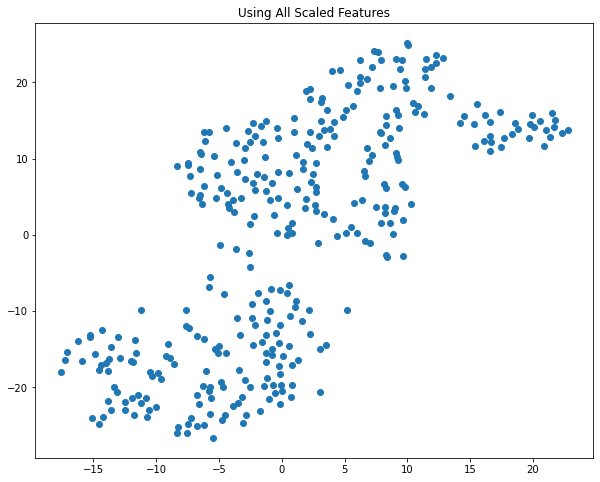

In [131]:
plt.figure(figsize=(10,8))
plt.title('Using All Scaled Features')
plt.scatter(embed_scale[:,:1],embed_scale[:,1:])

# Fitting Kmeans - Clustering Using Scaled Data

### Finding Optimal Number of Clusters - Using Elbow Method and SSE Score, Silhouette score Analysis.
1. An Elbow somewhat appears around 10 clusters.
2. Average silhoutte score is highest around the same region before slowly increasing.(Aournd 0.28 - not good).

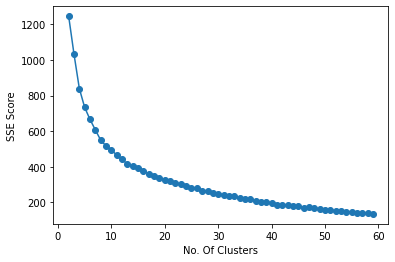

In [138]:
# calculate distortion for a range of number of cluster
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

distortions = []
sil_score = []
for i in range(2,60):
    cluster_film = KMeans(n_clusters = i, n_init=10, max_iter= 100).fit(data_film_scaled)
    distortions.append(cluster_film.inertia_)
    sil_score.append(silhouette_score(data_film_scaled, cluster_film.labels_, metric='euclidean'))
    
plt.xlabel('No. Of Clusters')
plt.ylabel('SSE Score')
plt.plot(range(2, 60), distortions, marker='o')
plt.savefig('Graphs/Clusters_SSE_plot.jpg')

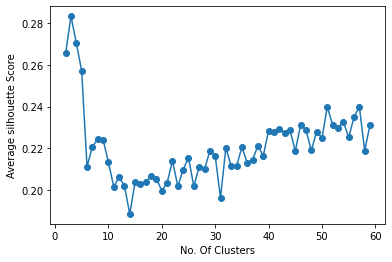

In [139]:
plt.xlabel('No. Of Clusters')
plt.ylabel('Average silhouette Score')
plt.plot(range(2, 60), sil_score, marker='o')

In [134]:
cluster_film = KMeans(n_clusters = 5, n_init=10, max_iter= 100).fit(data_film_scaled)
pred_film = cluster_film.labels_

### Lets Place the cluster labels back into dataframe and check which Movies got Clustered Together.

In [135]:
data_film_orig = data.loc[(film_filt)]
data_film_orig = pd.concat([data_film_orig, data_suppl], axis = 1)
data_film_orig['Cluster'] = pred_film
# saving clusters.
data_film_orig.to_csv('Data/Clusters_from_k_means_pca.csv')

# Visualizing and Analyzing the Clusters
1. Mostly Small Clusters are being formed, some larger clusters can be seen too. The larger clusters have plenty of overlap.
2. Investigating individual clusters and their silhoutte scores, most large clusters have lower than average silhoutte scores and the clusters with a reasonable size and above average silhoutte score are clusters of films by a particular director.

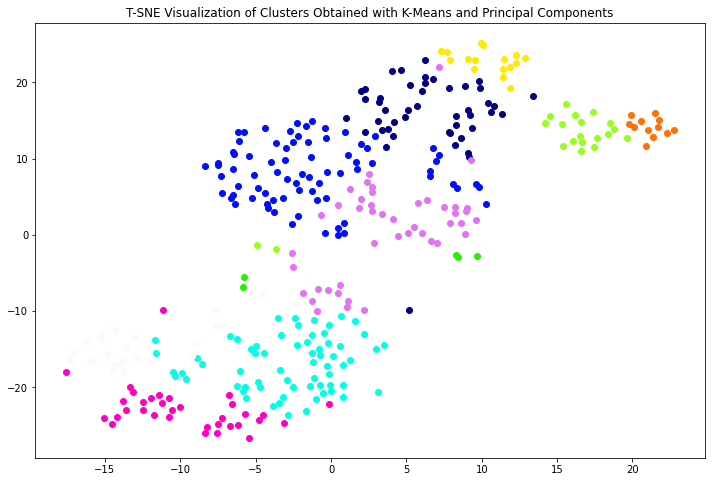

In [136]:
grouped_df = data_film_orig.groupby(['Cluster'])
embed_df = pd.DataFrame({'ax1': embed_scale[:,:1].ravel(), 'ax2': embed_scale[:,1:].ravel(), 'clusters': pred_film})
embed_pc_df = pd.DataFrame({'ax1': embed_pc[:,:1].ravel(), 'ax2': embed_pc[:,1:].ravel(), 'clusters': pred_film})
grouped_df_pc = embed_df.groupby('clusters')
plt.figure(figsize = (12,8))
plt.gca().set_prop_cycle(plt.cycler('color', plt.cm.gist_ncar(np.linspace(0, 1, 10))))
for i in range(10):
    plt.scatter(grouped_df_pc.get_group(i).ax1.tolist(), grouped_df_pc.get_group(i).ax2.tolist(), label = i)
plt.title('T-SNE Visualization of Clusters Obtained with K-Means and Principal Components')
plt.savefig('Graphs/Cluster_formed.jpg')
plt.show()

### Investigating Clusters

### Cluster Statistics - 
1. Checking Difference in Mean of Your Rating and IMDb Rating for clusters.
2. Mean difference in Runtime(Length).
3. Median Num Votes(Popularity) as data is Highly Skewed.
4. Median Year of Release.

In [142]:
data_film_cluster_stats = data_film_orig.groupby(['Cluster'])['Your Rating'].count()
data_film_cluster_stats = data_film_cluster_stats.to_frame('Count')
data_film_cluster_stats['your_imdb_Rating_Mean_Difference'] = data_film_orig.groupby(['Cluster'])['Your Rating'].mean() - data_film_orig.groupby(['Cluster'])['IMDb Rating'].mean()
data_film_cluster_stats['RunTime_Mean_Difference'] = data_film_orig.groupby(['Cluster'])['Runtime (mins)'].mean() - data_film_orig['Runtime (mins)'].mean()
data_film_cluster_stats['votes_Median_Difference'] = data_film_orig.groupby(['Cluster'])['Num Votes'].median() - data_film_orig['Num Votes'].median()
data_film_cluster_stats['Year_Median_diff'] = data_film_orig.groupby(['Cluster'])['Year'].median() - data_film_orig['Year'].median()
data_film_cluster_stats.sort_values('Count', ascending=False, inplace=True)

#### 1 Sample T-Test to compare population your rating and cluster your rating.

In [143]:
# Lets perform 1 sample two-tailed t test between population your rating (data_film) and sample clust_0
from scipy.stats import ttest_1samp

def ttest_1samp_cluster_pop(cluster_number):
    """ Testing to see if there is a significant difference between ratings given to films in cluster and 
    the population (Ratings given to all films).
    Null (h0) - There is no difference. (So, No preference to this cluster.)
    Alternate (h1) - There is a difference, these are rated higher/lower by the user.
    """
    pop_film = data_film['Your Rating'].tolist()
    print(f'Population Mean {np.mean(pop_film)}, degrees of freedom {len(pop_film)}')

    clust_3_sample = grouped_df.get_group(cluster_number)['Your Rating'].tolist()
    print(f'Sample mean {np.mean(clust_3_sample)}, degrees of freedom {len(clust_3_sample)}')

    tstat, pvalue = ttest_1samp(clust_3_sample, np.mean(pop_film))
    print('\nT-Stat for hypothesis test {} and P-value {}'.format(tstat, pvalue))
    print('T-critical for n = {}, alpha = 0.05 , look up in table'.format(len(clust_3_sample)-1))
    if pvalue<0.05:
        print('Statistically significant result, Reject the NUll - \nThere is siginificant difference between ratings given to films in this group and the population.')
    else:
        print('Statistically insignificant result, Failled to reject the null.')

In [144]:
def get_genre_cluster(genre = 'Animation'):
    return data_film_orig.loc[data_film.Genres.str.split(',', expand=True)[0] == genre].sort_values('Cluster')

### 1. Clusters of Interest on the basis of Mean Difference in Rating between Your Rating and IMDb Ratings

In [145]:
# Only Keeping clusters with atleast 3 movies
cluster_stat_large = data_film_cluster_stats.loc[(data_film_cluster_stats['Count'] >=3)]
cluster_stat_large.sort_values('Count').tail(10)

Count  your_imdb_Rating_Mean_Difference  RunTime_Mean_Difference  \
Cluster                                                                     
3            5                          0.060000               117.428986   
6           12                          0.550000                -0.121014   
5           16                         -0.106250                34.253986   
4           20                          0.135000               -10.821014   
9           25                         -1.516000                22.508986   
7           34                         -0.158824               -14.959250   
8           45                          0.077778                21.206763   
0           46                          0.102174                -3.262319   
2           65                         -0.523077               -10.032553   
1           77                          0.464935               -14.591794   

         votes_Median_Difference  Year_Median_diff  
Cluster                                             
3                      -127974.0              -9.0  
6                      -186780.0             -55.5  
5                      1182071.5             -14.5  
4                       135158.5             -33.5  
9                      -177093.0               5.0  
7                       -84389.0               0.5  
8                      -144835.0               2.0  
0                       563760.0              -3.0  
2                       -79649.0               3.0  
1                        36431.0               1.0

In [146]:
cluster_stat_large.sort_values('your_imdb_Rating_Mean_Difference').head(5)

Count  your_imdb_Rating_Mean_Difference  RunTime_Mean_Difference  \
Cluster                                                                     
9           25                         -1.516000                22.508986   
2           65                         -0.523077               -10.032553   
7           34                         -0.158824               -14.959250   
5           16                         -0.106250                34.253986   
3            5                          0.060000               117.428986   

         votes_Median_Difference  Year_Median_diff  
Cluster                                             
9                      -177093.0               5.0  
2                       -79649.0               3.0  
7                       -84389.0               0.5  
5                      1182071.5             -14.5  
3                      -127974.0              -9.0

In [147]:
cluster_stat_large.sort_values('your_imdb_Rating_Mean_Difference').tail(5)

Count  your_imdb_Rating_Mean_Difference  RunTime_Mean_Difference  \
Cluster                                                                     
8           45                          0.077778                21.206763   
0           46                          0.102174                -3.262319   
4           20                          0.135000               -10.821014   
1           77                          0.464935               -14.591794   
6           12                          0.550000                -0.121014   

         votes_Median_Difference  Year_Median_diff  
Cluster                                             
8                      -144835.0               2.0  
0                       563760.0              -3.0  
4                       135158.5             -33.5  
1                        36431.0               1.0  
6                      -186780.0             -55.5

### 2. Clusters of Interest on the basis of Mean difference in Runtime(Length).

In [148]:
cluster_stat_large = data_film_cluster_stats.loc[(data_film_cluster_stats['Count'] >=3)]
cluster_stat_large.sort_values('RunTime_Mean_Difference').head(5)

Count  your_imdb_Rating_Mean_Difference  RunTime_Mean_Difference  \
Cluster                                                                     
7           34                         -0.158824               -14.959250   
1           77                          0.464935               -14.591794   
4           20                          0.135000               -10.821014   
2           65                         -0.523077               -10.032553   
0           46                          0.102174                -3.262319   

         votes_Median_Difference  Year_Median_diff  
Cluster                                             
7                       -84389.0               0.5  
1                        36431.0               1.0  
4                       135158.5             -33.5  
2                       -79649.0               3.0  
0                       563760.0              -3.0

In [149]:
cluster_stat_large.sort_values('RunTime_Mean_Difference').tail(5)

Count  your_imdb_Rating_Mean_Difference  RunTime_Mean_Difference  \
Cluster                                                                     
6           12                          0.550000                -0.121014   
8           45                          0.077778                21.206763   
9           25                         -1.516000                22.508986   
5           16                         -0.106250                34.253986   
3            5                          0.060000               117.428986   

         votes_Median_Difference  Year_Median_diff  
Cluster                                             
6                      -186780.0             -55.5  
8                      -144835.0               2.0  
9                      -177093.0               5.0  
5                      1182071.5             -14.5  
3                      -127974.0              -9.0

### 3. Clusters of Interest on the basis of Median Num Votes(Popularity)

In [150]:
cluster_stat_large = data_film_cluster_stats.loc[(data_film_cluster_stats['Count'] >=3)]
cluster_stat_large.sort_values('votes_Median_Difference').head(5)

Count  your_imdb_Rating_Mean_Difference  RunTime_Mean_Difference  \
Cluster                                                                     
6           12                          0.550000                -0.121014   
9           25                         -1.516000                22.508986   
8           45                          0.077778                21.206763   
3            5                          0.060000               117.428986   
7           34                         -0.158824               -14.959250   

         votes_Median_Difference  Year_Median_diff  
Cluster                                             
6                      -186780.0             -55.5  
9                      -177093.0               5.0  
8                      -144835.0               2.0  
3                      -127974.0              -9.0  
7                       -84389.0               0.5

In [151]:
cluster_stat_large.sort_values('votes_Median_Difference').tail(5)

Count  your_imdb_Rating_Mean_Difference  RunTime_Mean_Difference  \
Cluster                                                                     
2           65                         -0.523077               -10.032553   
1           77                          0.464935               -14.591794   
4           20                          0.135000               -10.821014   
0           46                          0.102174                -3.262319   
5           16                         -0.106250                34.253986   

         votes_Median_Difference  Year_Median_diff  
Cluster                                             
2                       -79649.0               3.0  
1                        36431.0               1.0  
4                       135158.5             -33.5  
0                       563760.0              -3.0  
5                      1182071.5             -14.5

### 4. Clusters of Interest on the basis of Median Year of Release.

In [152]:
cluster_stat_large = data_film_cluster_stats.loc[(data_film_cluster_stats['Count'] >=3)]
cluster_stat_large.sort_values('Year_Median_diff').head(5)

Count  your_imdb_Rating_Mean_Difference  RunTime_Mean_Difference  \
Cluster                                                                     
6           12                          0.550000                -0.121014   
4           20                          0.135000               -10.821014   
5           16                         -0.106250                34.253986   
3            5                          0.060000               117.428986   
0           46                          0.102174                -3.262319   

         votes_Median_Difference  Year_Median_diff  
Cluster                                             
6                      -186780.0             -55.5  
4                       135158.5             -33.5  
5                      1182071.5             -14.5  
3                      -127974.0              -9.0  
0                       563760.0              -3.0

In [153]:
grouped_df = data_film_orig.groupby(['Cluster'])

In [158]:
# by positive rating, cluster 6 and 1.

# CLuster 3 Older Highly rated Movies.

#grouped_df.get_group(6).head(30)
#grouped_df.get_group(6).describe()
#ttest_1samp_cluster_pop(6)

# 2.B. PCA and K-Means Clustering (Using Encoded Categorical Data)
1. K-Means is a centroid based clustering algorithm that finds distinct clusters on the basis of the Euclidean distance. Multiple one-hot encoded categorical features used, results in a large feature set, which has been reduced using principal components analysis(50% variance). Used elbow method with within-cluster sum-of-squares and silhoutte score to assess quality of clusters. Finally clusters visualised using T-SNE. 
2. <b>Potential problems with this approach</b>, binary categorical columns don't make much sense with Euclidean distance. PCA is a simple linear dimensionality reduction technique, but consensus is out there for use with complex data. Again I found conflicting opinions on the use of PCA on binary categorical data. 
3. Will Try K-modes(categorical features), K-prototype(mixed features) clustering and DBScsan Clustering for density based clustering.

### Feature Engineering, Dropping Useless columns, One-hot Encodding Categorical Column like Genre, Director etc.

In [25]:
data_film.drop(['Genres', 'Directors'], axis = 1, inplace = True)

#### Lets see if we can Eye-ball clusters between ratings and popularity etc. 
Not really possible.

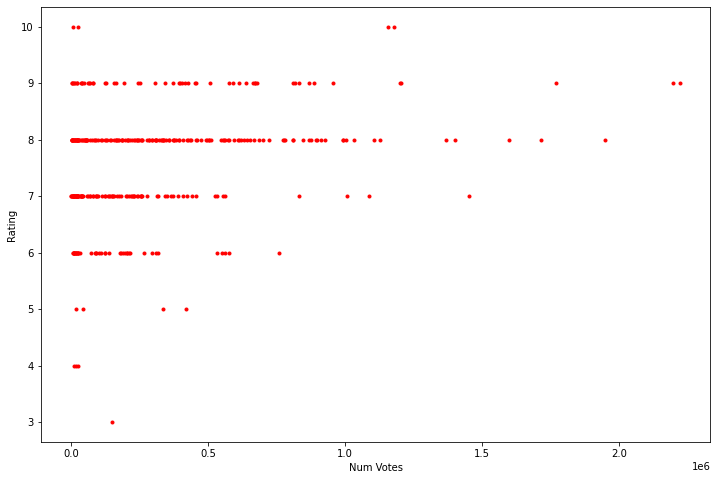

In [26]:
plt.figure(figsize=(12,8))
plt.plot( data_film['Num Votes'], data_film['Your Rating'].to_list(), 'r.')
plt.xlabel('Num Votes')
plt.ylabel('Rating')
plt.show()

#### Feature Engineering - One - Hot encode Genre, Directors and Dropping a few Columns, Convert Rated to Numerical

In [19]:
data_film = pd.get_dummies(data_film, prefix='Genre', columns=['Genre1'])
data_film = pd.get_dummies(data_film, prefix='Director', columns=['Director1'])
data_film[['Rated_Year', 'Rated_month', 'Rated_Day']] = data_film['Date Rated'].str.split('-', expand = True)
data_film.drop(['Rated_month', 'Rated_Day'], axis = 1, inplace = True)
data_film.drop('Date Rated', axis = 1, inplace = True)
data_film[['Release_Year', 'Release_month', 'Release_Day']] = data_film['Release Date'].str.split('-', expand = True)
data_film.drop(['Release_month', 'Release_Day'], axis = 1, inplace = True)
data_film.drop('Release Date', axis = 1, inplace = True)
data_film.drop(['Title Type', 'URL'], axis = 1, inplace = True)

KeyError: "None of [Index(['Genre1'], dtype='object')] are in the [columns]"

In [28]:
data_film = pd.get_dummies(data_film, prefix='Censor_rating', columns=['Rated'])
data_film = pd.get_dummies(data_film, prefix='Major_awards', columns=['Major_Awards'])
data_film = pd.get_dummies(data_film, prefix='Metascore_binned', columns=['Metascore_binned'])
data_film = pd.get_dummies(data_film, prefix='Box_office_binned', columns=['Box_office_binned'])
data_film = pd.get_dummies(data_film, prefix='Country', columns=['Country'])
data_film = pd.get_dummies(data_film, prefix='Language', columns=['Language'])

#### Making Copy as we'll drop Title and convert to numeric

In [29]:
data_film_num = data_film
data_film_num.drop(['Title'], axis = 1, inplace=True)
data_film_num.drop(['Release_Year'], axis = 1, inplace=True)
data_film_num['Rated_Year'] = data_film_num['Rated_Year'].astype(int)

#### Visualizing New Info

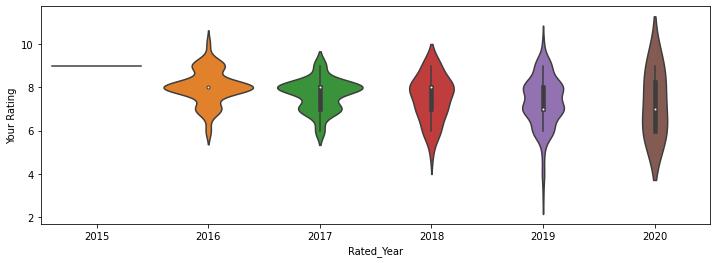

In [30]:
plt.figure(figsize=(12,4))
sns.violinplot(x = 'Rated_Year', y = 'Your Rating', data =data_film_num )

# Curse of Dimensionality - 304 Features for 345 samples. 

## Principal Components Analysis to Reduce Dimensionality of Data

#### Standardize Data
PCA requires data to be standardised/scaled otherwise the principal components found are basically meaningless due to different scales of features.

In [21]:
from sklearn.preprocessing import StandardScaler
data_film_scaled = StandardScaler().fit_transform(data_film[num_columns].values)

#### Restoring Indexes And Column Names

In [24]:
data_film_scaled_df = pd.DataFrame(data = data_film_scaled, index = data_film[num_columns].index, columns = data_film[num_columns].columns)

#### Lets Target that 50% Percent of the Variance is explained by the principal components - Explained by 107 Features.

In [30]:
data_film_scaled_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 345 entries, tt1010048 to tt0993846
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Your Rating     345 non-null    float64
 1   IMDb Rating     345 non-null    float64
 2   Runtime (mins)  345 non-null    float64
 3   Year            345 non-null    float64
 4   Num Votes       345 non-null    float64
dtypes: float64(5)
memory usage: 16.2+ KB


In [33]:
from sklearn.decomposition import PCA

target_variance = 0.50

for i in range(len(data_film_scaled_df.columns)):
    pca_film = PCA(n_components=i)
    pca_components_film = pca_film.fit_transform(data_film_scaled_df)
    #print(f'Total Explained Variance is {np.sum(pca_film.explained_variance_ratio_)}')
    if np.sum(pca_film.explained_variance_ratio_) > target_variance:
        #print(f'No of Components that explain 50% of Variance: {i}')
        break

print(f'No of Components that explain 50% of Variance: {i}')

No of Components that explain 50% of Variance: 1


### Checking important Features for First Principal Component
No single features dominates, which is good.

In [34]:
first_comp = pca_film.components_[0]
# Creating Dataframe for correspoding Columns in original Dataframe
first_comps = pd.DataFrame(zip(first_comp, data_film_scaled_df.columns), columns = ['Weights', 'Features'])
first_comps['abs_weights']=first_comps['Weights'].apply(lambda x: np.abs(x))
first_comps.sort_values('abs_weights', ascending=False)[:10]

Weights        Features  abs_weights
1  0.594765     IMDb Rating     0.594765
0  0.534559     Your Rating     0.534559
4  0.438943       Num Votes     0.438943
3 -0.378164            Year     0.378164
2  0.157549  Runtime (mins)     0.157549

In [35]:
list_pca_film = list(pca_components_film)

## Visualizing the High Dimensional data and Principal Components using T-SNE
Some clusters are visible by eye in the tsne output of the pricipal components, lets see if the Clustering algorithm picks this up.

In [36]:
from sklearn.manifold import TSNE
embed_scale = TSNE(n_components=2).fit_transform(data_film_scaled_df)
embed_pc = TSNE(n_components=2).fit_transform(pca_components_film)

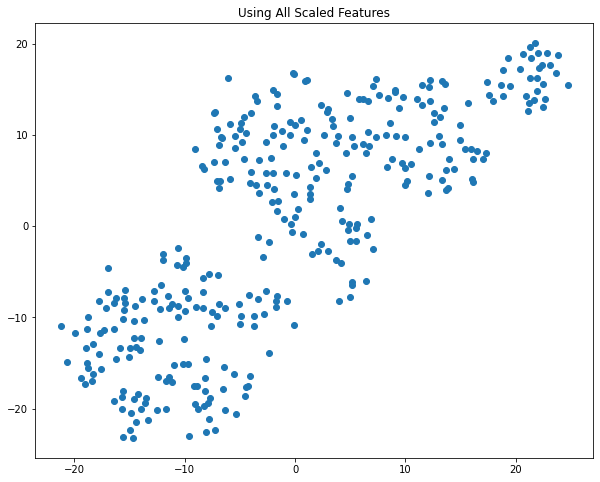

In [37]:
plt.figure(figsize=(10,8))
plt.title('Using All Scaled Features')
plt.scatter(embed_scale[:,:1],embed_scale[:,1:])

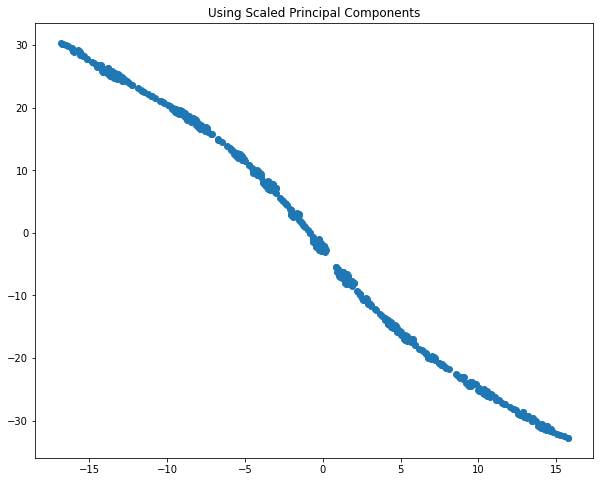

In [38]:
plt.figure(figsize=(10,8))
plt.title('Using Scaled Principal Components')
plt.scatter(embed_pc[:,:1],embed_pc[:,1:])

# Fitting Kmeans - Clustering Using Principal Components

### Finding Optimal Number of Clusters - Using Elbow Method and SSE Score, Silhouette score Analysis.
1. An Elbow somewhat appears around 90 clusters.
2. Average silhoutte score is lowest around the same region before slowly increasing.(Aournd 0.35).

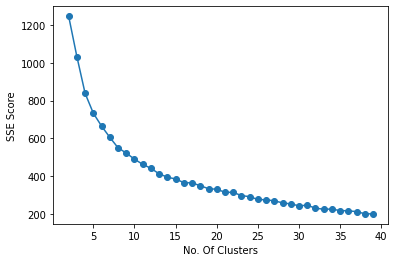

In [45]:
# calculate distortion for a range of number of cluster
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

distortions = []
sil_score = []
for i in range(2,40):
    cluster_film = KMeans(n_clusters = i, n_init=10, max_iter= 100).fit(data_film_scaled)
    distortions.append(cluster_film.inertia_)
    sil_score.append(silhouette_score(data_film_scaled, cluster_film.labels_, metric='euclidean'))
    
plt.xlabel('No. Of Clusters')
plt.ylabel('SSE Score')
plt.plot(range(2, 40), distortions, marker='o')
plt.savefig('Graphs/Clusters_SSE_plot.jpg')

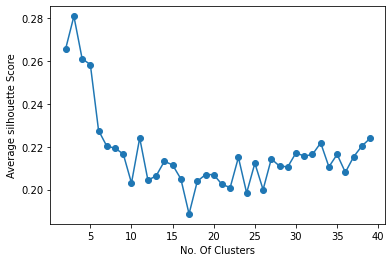

In [46]:
plt.xlabel('No. Of Clusters')
plt.ylabel('Average silhouette Score')
plt.plot(range(2, 40), sil_score, marker='o')

In [53]:
cluster_film = KMeans(n_clusters = 10, n_init=10, max_iter= 100).fit(data_film_scaled)
pred_film = cluster_film.labels_

### Lets Place the cluster labels back into dataframe and check which Movies got Clustered Together.

In [54]:
data_film_orig = data.loc[(film_filt)]
data_film_orig = pd.concat([data_film_orig, data_suppl], axis = 1)
data_film_orig['Cluster'] = pred_film
# saving clusters.
data_film_orig.to_csv('Data/Clusters_from_k_means_pca.csv')

# Visualizing and Analyzing the Clusters
1. Mostly Small Clusters are being formed, some larger clusters can be seen too. The larger clusters have plenty of overlap.
2. Investigating individual clusters and their silhoutte scores, most large clusters have lower than average silhoutte scores and the clusters with a reasonable size and above average silhoutte score are clusters of films by a particular director.

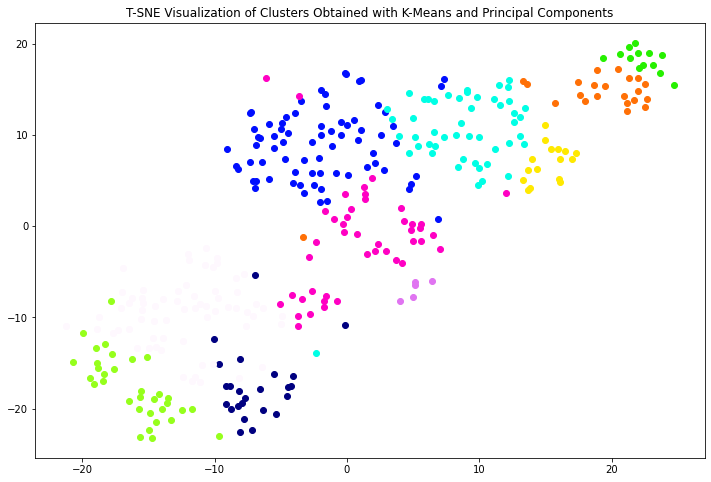

In [55]:
grouped_df = data_film_orig.groupby(['Cluster'])
embed_df = pd.DataFrame({'ax1': embed_scale[:,:1].ravel(), 'ax2': embed_scale[:,1:].ravel(), 'clusters': pred_film})
embed_pc_df = pd.DataFrame({'ax1': embed_pc[:,:1].ravel(), 'ax2': embed_pc[:,1:].ravel(), 'clusters': pred_film})
grouped_df_pc = embed_df.groupby('clusters')
plt.figure(figsize = (12,8))
plt.gca().set_prop_cycle(plt.cycler('color', plt.cm.gist_ncar(np.linspace(0, 1, 10))))
for i in range(10):
    plt.scatter(grouped_df_pc.get_group(i).ax1.tolist(), grouped_df_pc.get_group(i).ax2.tolist(), label = i)
plt.title('T-SNE Visualization of Clusters Obtained with K-Means and Principal Components')
plt.savefig('Graphs/Cluster_formed.jpg')
plt.show()

### Investigating Clusters

### Cluster Statistics - 
1. Checking Difference in Mean of Your Rating and IMDb Rating for clusters.
2. Mean difference in Runtime(Length).
3. Median Num Votes(Popularity) as data is Highly Skewed.
4. Median Year of Release.

In [56]:
data_film_cluster_stats = data_film_orig.groupby(['Cluster'])['Your Rating'].count()
data_film_cluster_stats = data_film_cluster_stats.to_frame('Count')
data_film_cluster_stats['your_imdb_Rating_Mean_Difference'] = data_film_orig.groupby(['Cluster'])['Your Rating'].mean() - data_film_orig.groupby(['Cluster'])['IMDb Rating'].mean()
data_film_cluster_stats['RunTime_Mean_Difference'] = data_film_orig.groupby(['Cluster'])['Runtime (mins)'].mean() - data_film_orig['Runtime (mins)'].mean()
data_film_cluster_stats['votes_Median_Difference'] = data_film_orig.groupby(['Cluster'])['Num Votes'].median() - data_film_orig['Num Votes'].median()
data_film_cluster_stats['Year_Median_diff'] = data_film_orig.groupby(['Cluster'])['Year'].median() - data_film_orig['Year'].median()
data_film_cluster_stats.sort_values('Count', ascending=False, inplace=True)

#### 1 Sample T-Test to compare population your rating and cluster your rating.

In [57]:
# Lets perform 1 sample two-tailed t test between population your rating (data_film) and sample clust_0
from scipy.stats import ttest_1samp

def ttest_1samp_cluster_pop(cluster_number):
    """ Testing to see if there is a significant difference between ratings given to films in cluster and 
    the population (Ratings given to all films).
    Null (h0) - There is no difference. (So, No preference to this cluster.)
    Alternate (h1) - There is a difference, these are rated higher/lower by the user.
    """
    pop_film = data_film['Your Rating'].tolist()
    print(f'Population Mean {np.mean(pop_film)}, degrees of freedom {len(pop_film)}')

    clust_3_sample = grouped_df.get_group(cluster_number)['Your Rating'].tolist()
    print(f'Sample mean {np.mean(clust_3_sample)}, degrees of freedom {len(clust_3_sample)}')

    tstat, pvalue = ttest_1samp(clust_3_sample, np.mean(pop_film))
    print('\nT-Stat for hypothesis test {} and P-value {}'.format(tstat, pvalue))
    print('T-critical for n = {}, alpha = 0.05 , look up in table'.format(len(clust_3_sample)-1))
    if pvalue<0.05:
        print('Statistically significant result, Reject the NUll - \nThere is siginificant difference between ratings given to films in this group and the population.')
    else:
        print('Statistically insignificant result, Failled to reject the null.')

In [58]:
def get_genre_cluster(genre = 'Animation'):
    return data_film_orig.loc[data_film.Genres.str.split(',', expand=True)[0] == genre].sort_values('Cluster')

### 1. Clusters of Interest on the basis of Mean Difference in Rating between Your Rating and IMDb Ratings

In [59]:
# Only Keeping clusters with atleast 3 movies
cluster_stat_large = data_film_cluster_stats.loc[(data_film_cluster_stats['Count'] >=3)]
cluster_stat_large.sort_values('Count').tail(10)

Count  your_imdb_Rating_Mean_Difference  RunTime_Mean_Difference  \
Cluster                                                                     
8            5                          0.060000               117.428986   
3           13                          0.676923                -1.371014   
5           16                         -0.106250                34.253986   
6           22                         -0.036364               -12.825560   
0           24                         -1.558333                22.295652   
4           33                         -0.127273               -14.431621   
7           44                          0.038636                21.947167   
2           49                          0.142857                -1.493463   
9           66                         -0.533333               -10.371014   
1           73                          0.494521               -15.097042   

         votes_Median_Difference  Year_Median_diff  
Cluster                                             
8                      -127974.0              -9.0  
3                      -191826.0             -55.0  
5                      1182071.5             -14.5  
6                       185071.0             -29.0  
0                      -176964.5               5.0  
4                       -80321.0               1.0  
7                      -149425.0               1.5  
2                       466888.0              -1.0  
9                       -79870.5               3.0  
1                        19923.0               1.0

In [61]:
cluster_stat_large.sort_values('your_imdb_Rating_Mean_Difference').head(5)

Count  your_imdb_Rating_Mean_Difference  RunTime_Mean_Difference  \
Cluster                                                                     
0           24                         -1.558333                22.295652   
9           66                         -0.533333               -10.371014   
4           33                         -0.127273               -14.431621   
5           16                         -0.106250                34.253986   
6           22                         -0.036364               -12.825560   

         votes_Median_Difference  Year_Median_diff  
Cluster                                             
0                      -176964.5               5.0  
9                       -79870.5               3.0  
4                       -80321.0               1.0  
5                      1182071.5             -14.5  
6                       185071.0             -29.0

In [62]:
cluster_stat_large.sort_values('your_imdb_Rating_Mean_Difference').tail(5)

Count  your_imdb_Rating_Mean_Difference  RunTime_Mean_Difference  \
Cluster                                                                     
7           44                          0.038636                21.947167   
8            5                          0.060000               117.428986   
2           49                          0.142857                -1.493463   
1           73                          0.494521               -15.097042   
3           13                          0.676923                -1.371014   

         votes_Median_Difference  Year_Median_diff  
Cluster                                             
7                      -149425.0               1.5  
8                      -127974.0              -9.0  
2                       466888.0              -1.0  
1                        19923.0               1.0  
3                      -191826.0             -55.0

### 2. Clusters of Interest on the basis of Mean difference in Runtime(Length).

In [63]:
cluster_stat_large = data_film_cluster_stats.loc[(data_film_cluster_stats['Count'] >=3)]
cluster_stat_large.sort_values('RunTime_Mean_Difference').head(5)

Count  your_imdb_Rating_Mean_Difference  RunTime_Mean_Difference  \
Cluster                                                                     
1           73                          0.494521               -15.097042   
4           33                         -0.127273               -14.431621   
6           22                         -0.036364               -12.825560   
9           66                         -0.533333               -10.371014   
2           49                          0.142857                -1.493463   

         votes_Median_Difference  Year_Median_diff  
Cluster                                             
1                        19923.0               1.0  
4                       -80321.0               1.0  
6                       185071.0             -29.0  
9                       -79870.5               3.0  
2                       466888.0              -1.0

In [64]:
cluster_stat_large.sort_values('RunTime_Mean_Difference').tail(5)

Count  your_imdb_Rating_Mean_Difference  RunTime_Mean_Difference  \
Cluster                                                                     
3           13                          0.676923                -1.371014   
7           44                          0.038636                21.947167   
0           24                         -1.558333                22.295652   
5           16                         -0.106250                34.253986   
8            5                          0.060000               117.428986   

         votes_Median_Difference  Year_Median_diff  
Cluster                                             
3                      -191826.0             -55.0  
7                      -149425.0               1.5  
0                      -176964.5               5.0  
5                      1182071.5             -14.5  
8                      -127974.0              -9.0

### 3. Clusters of Interest on the basis of Median Num Votes(Popularity)

In [65]:
cluster_stat_large = data_film_cluster_stats.loc[(data_film_cluster_stats['Count'] >=3)]
cluster_stat_large.sort_values('votes_Median_Difference').head(5)

Count  your_imdb_Rating_Mean_Difference  RunTime_Mean_Difference  \
Cluster                                                                     
3           13                          0.676923                -1.371014   
0           24                         -1.558333                22.295652   
7           44                          0.038636                21.947167   
8            5                          0.060000               117.428986   
4           33                         -0.127273               -14.431621   

         votes_Median_Difference  Year_Median_diff  
Cluster                                             
3                      -191826.0             -55.0  
0                      -176964.5               5.0  
7                      -149425.0               1.5  
8                      -127974.0              -9.0  
4                       -80321.0               1.0

In [66]:
cluster_stat_large.sort_values('votes_Median_Difference').tail(5)

Count  your_imdb_Rating_Mean_Difference  RunTime_Mean_Difference  \
Cluster                                                                     
9           66                         -0.533333               -10.371014   
1           73                          0.494521               -15.097042   
6           22                         -0.036364               -12.825560   
2           49                          0.142857                -1.493463   
5           16                         -0.106250                34.253986   

         votes_Median_Difference  Year_Median_diff  
Cluster                                             
9                       -79870.5               3.0  
1                        19923.0               1.0  
6                       185071.0             -29.0  
2                       466888.0              -1.0  
5                      1182071.5             -14.5

### 4. Clusters of Interest on the basis of Median Year of Release.

In [67]:
cluster_stat_large = data_film_cluster_stats.loc[(data_film_cluster_stats['Count'] >=3)]
cluster_stat_large.sort_values('Year_Median_diff').head(5)

Count  your_imdb_Rating_Mean_Difference  RunTime_Mean_Difference  \
Cluster                                                                     
3           13                          0.676923                -1.371014   
6           22                         -0.036364               -12.825560   
5           16                         -0.106250                34.253986   
8            5                          0.060000               117.428986   
2           49                          0.142857                -1.493463   

         votes_Median_Difference  Year_Median_diff  
Cluster                                             
3                      -191826.0             -55.0  
6                       185071.0             -29.0  
5                      1182071.5             -14.5  
8                      -127974.0              -9.0  
2                       466888.0              -1.0

In [68]:
grouped_df = data_film_orig.groupby(['Cluster'])

In [72]:
# by positive rating, cluster 3 and 1.

# CLuster 3 Older Highly rated Movies.

grouped_df.get_group(3).head(30)
grouped_df.get_group(3).describe()
ttest_1samp_cluster_pop(3)

Population Mean 7.58840579710145, degrees of freedom 345
Sample mean 8.846153846153847, degrees of freedom 13

T-Stat for hypothesis test 6.5843327086301064 and P-value 2.5962259925028664e-05
T-critical for n = 12, alpha = 0.05 , look up in table
Statistically significant result, Reject the NUll - 
There is siginificant difference between ratings given to films in this group and the population.


In [75]:
grouped_df.get_group(1).head(30)
grouped_df.get_group(1).describe()
ttest_1samp_cluster_pop(1)

Population Mean 7.58840579710145, degrees of freedom 345
Sample mean 8.136986301369863, degrees of freedom 73

T-Stat for hypothesis test 13.538146299512084 and P-value 1.7894477600796352e-21
T-critical for n = 72, alpha = 0.05 , look up in table
Statistically significant result, Reject the NUll - 
There is siginificant difference between ratings given to films in this group and the population.


In [ ]:
# 7, 8, 2 
# negative - 0, 9, 4

In [97]:
grouped_df.get_group(4).head(30)
#grouped_df.get_group(4).describe()
#ttest_1samp_cluster_pop(4)

Your Rating  Date Rated  \
tt0112697            7  2019-04-23   
tt1216475            3  2019-10-13   
tt1336608            6  2016-10-27   
tt1365519            6  2019-02-27   
tt1560220            6  2020-03-25   
tt1588173            6  2019-03-11   
tt1592281            8  2019-06-28   
tt1606389            6  2019-02-22   
tt1935859            7  2017-04-04   
tt2229499            7  2016-12-04   
tt0265208            6  2017-02-08   
tt2704998            6  2019-07-27   
tt2788710            6  2016-04-21   
tt3165612            7  2019-03-03   
tt0343660            6  2018-09-01   
tt3606752            7  2017-10-24   
tt0367594            7  2017-04-04   
tt0371724            7  2019-08-23   
tt3731562            7  2018-03-02   
tt3859980            6  2019-08-23   
tt4052882            7  2016-09-12   
tt0493949            7  2017-03-29   
tt5884052            6  2019-06-02   
tt5952332            7  2019-08-23   
tt6859352            7  2019-03-25   
tt0758752            7  2018-05-30   
tt0758766            7  2018-05-04   
tt8079248            6  2019-09-11   
tt0815236            6  2017-02-08   
tt8266310            6  2019-11-15   

                                                 Title  \
tt0112697                                     Clueless   
tt1216475                                       Cars 2   
tt1336608                                 Rock of Ages   
tt1365519                                  Tomb Raider   
tt1560220                       Zombieland: Double Tap   
tt1588173                                  Warm Bodies   
tt1592281                              Take This Waltz   
tt1606389                                      The Vow   
tt1935859  Miss Peregrine's Home for Peculiar Children   
tt2229499                                      Don Jon   
tt0265208                           The Girl Next Door   
tt2704998                                   Game Night   
tt2788710                                The Interview   
tt3165612                   Sleeping with Other People   
tt0343660                               50 First Dates   
tt3606752                                       Cars 3   
tt0367594            Charlie and the Chocolate Factory   
tt0371724         The Hitchhiker's Guide to the Galaxy   
tt3731562                           Kong: Skull Island   
tt3859980                                 Mohenjo Daro   
tt4052882                                 The Shallows   
tt0493949                            Ramona and Beezus   
tt5884052                    Pok�mon Detective Pikachu   
tt5952332                                  Amanda Knox   
tt6859352                            Support the Girls   
tt0758752                           Love & Other Drugs   
tt0758766                             Music and Lyrics   
tt8079248                                    Yesterday   
tt0815236                       She's Out of My League   
tt8266310                         Blinded by the Light   

                                             URL Title Type  IMDb Rating  \
tt0112697  https://www.imdb.com/title/tt0112697/      movie          6.8   
tt1216475  https://www.imdb.com/title/tt1216475/      movie          6.1   
tt1336608  https://www.imdb.com/title/tt1336608/      movie          5.9   
tt1365519  https://www.imdb.com/title/tt1365519/      movie          6.3   
tt1560220  https://www.imdb.com/title/tt1560220/      movie          6.8   
tt1588173  https://www.imdb.com/title/tt1588173/      movie          6.9   
tt1592281  https://www.imdb.com/title/tt1592281/      movie          6.5   
tt1606389  https://www.imdb.com/title/tt1606389/      movie          6.8   
tt1935859  https://www.imdb.com/title/tt1935859/      movie          6.7   
tt2229499  https://www.imdb.com/title/tt2229499/      movie          6.5   
tt0265208  https://www.imdb.com/title/tt0265208/      movie          6.7   
tt2704998  https://www.imdb.com/title/tt2704998/      movie          6.9   
tt2788710  https://www.imdb.com/title/tt27887

## Interpreting Largest Clusters

#### Cluster 11 - Cluster of Romantic Comedies, Romantic Dramas.
1. 21 Films.
2. Rated favourably compared to IMDb.
3. Slighly shorter than mean , reasonably popular, newish movies. Rated Teen or Restriced.
4. All Major awards contendors and reasonably succesful films.($ 10-100Million).
5. Rated higher than your rating mean, Statistically Significant (1 sample T-test) group compared to all Your Ratings. (Definite Preference)

In [144]:
#grouped_df.get_group(11).head(30)
#grouped_df.get_group(11).describe()
ttest_1samp_cluster_pop(11)

Population Mean 7.58840579710145, degrees of freedom 345
Sample mean 8.0, degrees of freedom 21

T-Stat for hypothesis test 2.9822833303752154 and P-value 0.007363578828277226
T-critical for n = 20, alpha = 0.05 , look up in table
Statistically significant result, Reject the NUll - 
There is siginificant difference between ratings given to films in this group and the population.


#### Cluster 19 - Cluster of Newer Hindi Comedy, Drama, Action Movies.
1. 18 Films.
2. Rated very unfavourably compared to IMDb.
3. Newer Movies.
4. Rated much lower than your rating mean, Statistically Significant (1 sample T-test) group compared to all Your Ratings. (Definite Dislike)

In [152]:
#grouped_df.get_group(19).head(30)
#grouped_df.get_group(19).describe()
ttest_1samp_cluster_pop(19)

Population Mean 7.58840579710145, degrees of freedom 345
Sample mean 6.5, degrees of freedom 18

T-Stat for hypothesis test -4.999971840087577 and P-value 0.00010958470697740056
T-critical for n = 17, alpha = 0.05 , look up in table
Statistically significant result, Reject the NUll - 
There is siginificant difference between ratings given to films in this group and the population.


#### Cluster 32 - Mostly Newer Action, Adventure, Superhero movies.
1. 17 Films.
2. Rated almost the same as compared to IMdb
3. Mostly Newer Movies, not awards contendors, high-mid critic ratings.
4. Mostly Teen rated movies.
5. Rated the same as mean your rating, Statistically Insignificant (1 sample T-test) group compared to all Your Ratings. (No preference either way)

In [98]:
#print(grouped_df.get_group(32).describe())
#grouped_df.get_group(32).head(30)
#ttest_1samp_cluster_pop(32)

#### Cluster 34 - Mostly Newer Hindi, Action, Drama, Biographical movies.
1. 16 Films.
2. Rated lowered compared to IMdb.
3. Rated much lower than your rating mean, Statistically Significant (1 sample T-test) group compared to all Your Ratings. (Definite Dislike)

In [170]:
#print(grouped_df.get_group(34).describe())
#grouped_df.get_group(34).head(30)
ttest_1samp_cluster_pop(34)

Population Mean 7.58840579710145, degrees of freedom 345
Sample mean 6.9375, degrees of freedom 16

T-Stat for hypothesis test -2.317194224706545 and P-value 0.03503907106145302
T-critical for n = 15, alpha = 0.05 , look up in table
Statistically significant result, Reject the NUll - 
There is siginificant difference between ratings given to films in this group and the population.


#### Cluster 6 - Mostly Romantic Comedies that weren't critically acclaimed.
1. 16 Films.
2. Rated about the same as IMDb.
3. Reasonably succesful and popular.
4. Rated much lower than your rating mean, Statistically Significant (1 sample T-test) group compared to all Your Ratings. (Dislike, but already low rated movies.)

In [175]:
#print(grouped_df.get_group(6).describe())
grouped_df.get_group(6).head(30)
ttest_1samp_cluster_pop(6)

Population Mean 7.58840579710145, degrees of freedom 345
Sample mean 6.75, degrees of freedom 16

T-Stat for hypothesis test -4.329508919383558 and P-value 0.0005954145795448534
T-critical for n = 15, alpha = 0.05 , look up in table
Statistically significant result, Reject the NUll - 
There is siginificant difference between ratings given to films in this group and the population.


#### Cluster 11 - acclaimed biographical dramas
1. Rated the same as IMDb
2. Statistically insiginificant.

#### Cluster 7 - Critically lauded, Dramedies. Mostly Rated R.
1. Rated the same as IMDb
2. Statistically insiginificant.

#### Cluster 9 - Critically acclaimed, Dramas. Almost all Rated R.
1. Rated higher than IMDb
2. Rated higher than your rating mean, Statistically Significant (1 sample T-test) group compared to all Your Ratings. (Definite Preference)

In [233]:
#print(grouped_df.get_group(9).describe())
grouped_df.get_group(9).head(30)
ttest_1samp_cluster_pop(9)

Population Mean 7.58840579710145, degrees of freedom 345
Sample mean 8.166666666666666, degrees of freedom 12

T-Stat for hypothesis test 5.146196863219417 and P-value 0.0003201320841974889
T-critical for n = 11, alpha = 0.05 , look up in table
Statistically significant result, Reject the NUll - 
There is siginificant difference between ratings given to films in this group and the population.


##  Interpreting Clusters with Skewed Satistics.

#### Cluster 55 - Edgar Wright Comedies.
1. 3 Films.
2. Rated Much Higher than IMDb users.
3. Statistically Insignificant Result.

#### Cluster 85 - Documentaries, mostly F1.
1. 5 Films.
2. Rated Much Higher than IMDb users.
3. Statistically Insignificant Result.

#### Cluster 22 - Films by Wes Anderson.
1. 4 Films.
2. Rated Much more Favourably.
3. Statistically Insignificant Result.

#### Cluster 13 -Films by  Steven Spielberg.
1. 3 Films.
2. Rated Much more favourably.
3. Statistically Insignificant Result.

#### Cluster 29 - Films by  Dean Deblois - How To train Your Dragon series.
1. 3 Films.
2. Rated Much more favourably.
3. Statistically Insignificant Result.

#### Cluster 38 - Christopher Nolan Films
1. 6 Films.
2. Rated less favourably than IMDb.
3. Statistically Insignificant Result.

#### Cluster 3 - Stayajit Ray Films
1. 4 Films.
2. Rated about the same as IMDB.
3. Almost statistically significant.

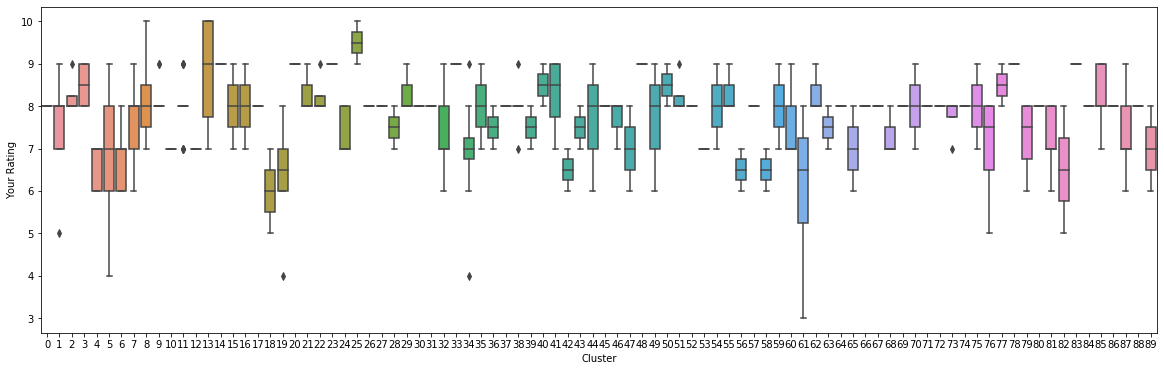

In [234]:
plt.figure(figsize=(20,6))
sns.boxplot(x = 'Cluster', y = 'Your Rating', data = data_film_orig)

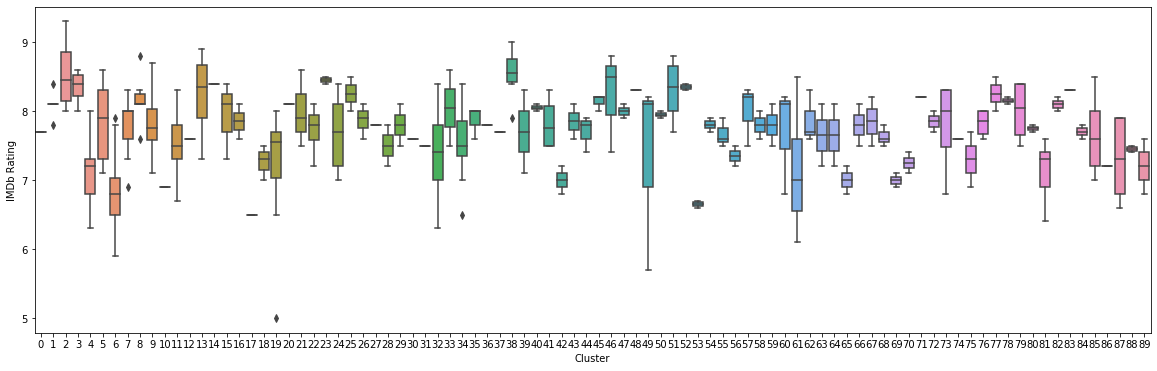

In [235]:
plt.figure(figsize=(20,6))
sns.boxplot(x = 'Cluster', y = 'IMDb Rating', data = data_film_orig)

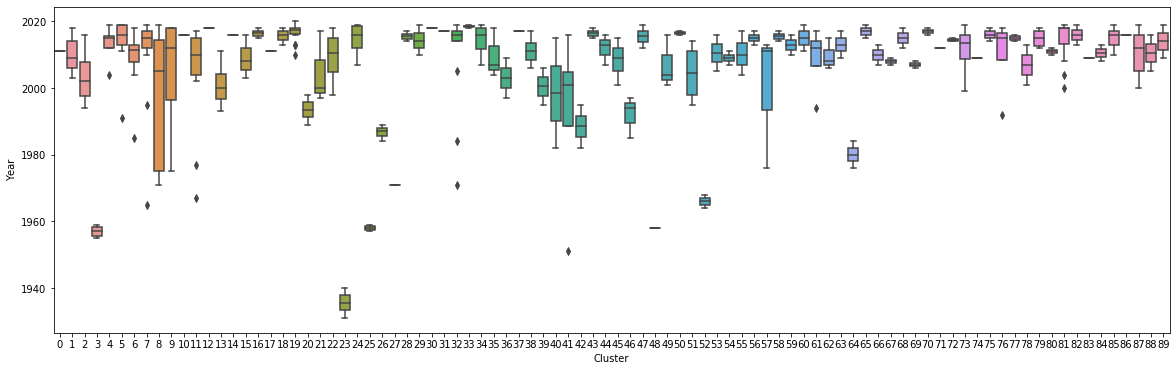

In [236]:
plt.figure(figsize=(20,6))
sns.boxplot(x = 'Cluster', y = 'Year', data = data_film_orig)

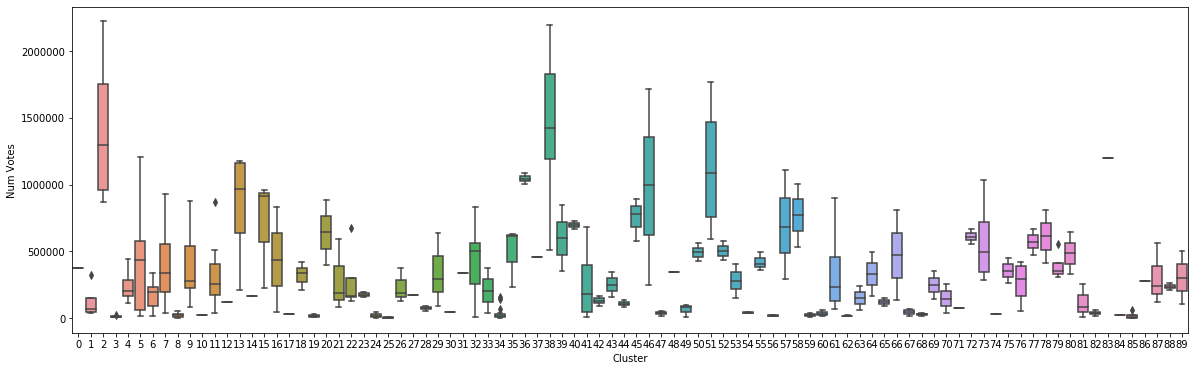

In [237]:
plt.figure(figsize=(20,6))
sns.boxplot(x = 'Cluster', y = 'Num Votes', data = data_film_orig)